# QUANTUM STATE PREPARATION

## Goal.

Write a Qiskit function that takes a $2^n$ dimensional vector, $\psi \in \mathbb{C}^{2^n}$, such that $||\psi||_2=1$, and outputs a circuit, $U$, such that
$$
U \ket{0}_n = \sum_{x\in \mathbb{F}_2^n} \psi_x \ket{x}_n .
$$

We will provide a construction based on induction that uses $R_Z$ multiplexers and the inverse cosine function.


In [1]:
pip install qiskit numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
from qiskit import quantum_info 
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import DiagonalGate
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile
import qiskit.circuit.library
from qiskit.circuit.library.standard_gates import GlobalPhaseGate

import matplotlib as mpl
import numpy as np

The following function returns a quantum circuit that produces the desired quantum state.

In [3]:
# Define a function that prepares an $n$-qubit state $\psi$

def qsp(psi):
    
# Check that the length of the vector psi is a power of 2
    if np.log2(len(psi)) == int(np.log2(len(psi))):
        n = int(np.log2(len(psi)))
    else:
        return False
        
# Define the vector consisting of moduli of entries in psi
    psi_abs = [np.abs(x) for x in psi] 

# case n=1
    
    if n == 1:
        theta_0 = 2 * np.arccos(psi_abs[0])
        quantum_register = QuantumRegister(size=1, name="q")
        qsp_circuit = QuantumCircuit(quantum_register, name="qsp n=1")
        
# Applying an equivalent of RY gate to qubit 0
        qsp_circuit.sdg(quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.rz(theta_0, quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.s(quantum_register[0])

# case n=2 
    
    elif n == 2:
        theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi_abs[:2]))))
        theta_10 = 2 * np.arccos(psi_abs[0] / np.sqrt(np.sum(np.square(psi_abs[:2]))))
        theta_11 = 2 * np.arccos(psi_abs[2] / np.sqrt(np.sum(np.square(psi_abs[2:]))))
        quantum_register = QuantumRegister(size=2, name="q")
        qsp_circuit = QuantumCircuit(quantum_register, name="qsp")
        
# Applying an equivalent of RY gate to qubit 1
        qsp_circuit.sdg(quantum_register[1])
        qsp_circuit.h(quantum_register[1])
        qsp_circuit.rz(theta_0, quantum_register[1])
        qsp_circuit.h(quantum_register[1])
        qsp_circuit.s(quantum_register[1])
        
# Applying an X gate to qubit 1
        
        qsp_circuit.x(quantum_register[1])

# Applying an equivalent of a controlled RY gate with control on qubit 1, target on qubit 0

        qsp_circuit.sdg(quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.crz(theta_10, quantum_register[1], quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.s(quantum_register[0])
        
# Applying an X gate to qubit 1
        
        qsp_circuit.x(quantum_register[1])

# Applying an equivalent of a controlled RY gate with control on qubit 1, target on qubit 0

        qsp_circuit.sdg(quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.crz(theta_11, quantum_register[1], quantum_register[0])
        qsp_circuit.h(quantum_register[0])
        qsp_circuit.s(quantum_register[0])

# case n bigger than 2
    
    elif n >= 3:
        theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi_abs[::2]))))
        quantum_register = QuantumRegister(size=n, name="q")
        qsp_circuit = QuantumCircuit(quantum_register, name="qsp")
        if np.sqrt(np.sum(np.square(psi_abs[::2]))) != 0: 
            
# Applying an equivalent of RY gate to the last qubit
            qsp_circuit.sdg(quantum_register[-1])
            qsp_circuit.h(quantum_register[-1])
            qsp_circuit.rz(theta_0, quantum_register[-1])
            qsp_circuit.h(quantum_register[-1])
            qsp_circuit.s(quantum_register[-1])  
        
# Applying an X gate to the last qubit
            qsp_circuit.x(quantum_register[-1])    
        
# Define psi_0, the n-qubit state within psi_abs        
            psi_abs_zero = [x/np.cos(theta_0/2) for x in psi_abs[::2]]
        
# Define psi_1, the n-qubit state within psi_abs         
            psi_abs_one = [x/np.sin(theta_0/2) for x in psi_abs[1::2]]
        
# Convert the circuit for psi_abs_zero into a gate and apply its 1 controlled version with the first n qubits as the target        
            c_psi_abs_zero_gate = qsp(psi_abs_zero).to_gate().control(1)
            qsp_circuit.append(c_psi_abs_zero_gate, [quantum_register[n-1]] + [quantum_register[i] for i in range(n-1)])
            qsp_circuit.x(quantum_register[-1])
        
# Convert the circuit for psi_abs_one into a gate and apply its 1 controlled version with the first n qubits as the target        
            c_psi_abs_one_gate = qsp(psi_abs_one).to_gate().control(1)
            qsp_circuit.append(c_psi_abs_one_gate, [quantum_register[n-1]] + [quantum_register[i] for i in range(n-1)])
        elif np.sqrt(np.sum(np.square(psi_abs[::2]))) == 0: 
            psi_abs_one = [x/np.sin(theta_0/2) for x in psi_abs[1::2]]
            
# Convert the circuit for psi_abs_one into a gate        
            c_psi_abs_one_gate = qsp(psi_abs_one).to_gate()
            qsp_circuit.append(c_psi_abs_one_gate, quantum_register[1:])
            qsp_circuit.x(quantum_register[0])
            
# Define the vector consisting of phases of each entry in psi
    psi_phases = [np.e**(1j*np.angle(x)) for x in psi]
    psi_phases_gate = DiagonalGate(psi_phases)
    
# Apply the suitable phase factors  
    qsp_circuit.append(psi_phases_gate, qsp_circuit.qubits)

# Return the constructed circuit as the output    
    return qsp_circuit 


We now explain the construction of this function. We start with the basic case of $n=1$ and build our way up to a general $n$.

## Comments about the case $n=1$.

Let $\ket{\psi} = \psi_0 \ket{0} + \psi_1 \ket{1}.$ 

Here, we assume that $\psi_0, \psi_1 \geq 0$, as we will take the phases into account later on. 
Define the following angle
\begin{align}
    \theta_{0}     = 2 \arccos \big(\psi_0 \big). 
\end{align}
Note that
 $$R_Y(\theta_0)\ket{0} = \cos\frac{\theta_0}{2}\ket{0}+\sin\frac{\theta_0}{2}\ket{1}.$$
$$R_Y(\theta_0)\ket{1} = -\sin\frac{\theta_0}{2}\ket{0}+\cos\frac{\theta_0}{2}\ket{1}.$$

$\psi$ will be the output of the following circuit. 

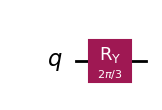

In [28]:
# Without loss of generality, suppose that psi is as given as a unit vector with positive entries.

psi = [1/2, np.sqrt(3)/2]

theta_0 = 2 * np.arccos(psi[0])

# Define the circuit that prepares the state psi

quantum_register = QuantumRegister(size=1, name="q")


qsp_circuit = QuantumCircuit(quantum_register, name="qsp")

qsp_circuit.ry(theta_0, quantum_register[0])

# Draw the circuit 

qsp_circuit.draw(output="mpl")

In [29]:
# Check the output of the circuit and compare it with psi

output = Statevector(qsp_circuit)
output.draw("latex")

<IPython.core.display.Latex object>

We want to use the $R_Z$ gate instead of the $R_Y$ gate. For this, we note some observations relating the Pauli $Y$ and $Z$ matrices.

It is known that
$$
X= HZH \quad \text{and} \quad Y = S X S^\dagger, \,\, \text{where }\,  S= P(\pi/2).
$$
for the phase matrix $P= \begin{bmatrix} 1 & 0 \\ 0 & e^{i\theta} \end{bmatrix}$. 
Therefore, 
$$
Y = S HZH S^\dagger,
$$
and since $(SH)^\dagger = H S^\dagger$, the matrix exponentiation gives
$$
R_Y(\theta) = e^{-i\theta Y/2}= S H e^{-i\theta Z/2} H S^\dagger= S H R_Z(\theta) H S^\dagger.
$$

We accordingly rewrite the above circuit using the $R_Z$ gate.

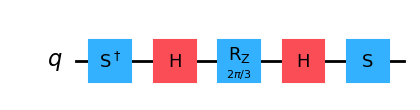

In [30]:
psi = [1/2, np.sqrt(3)/2]

theta_0 = 2 * np.arccos(psi[0])

# Define the circuit that prepares this state psi

quantum_register = QuantumRegister(size=1, name="q")

qsp_circuit = QuantumCircuit(quantum_register, name="qsp")

qsp_circuit.sdg(quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.rz(theta_0, quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.s(quantum_register[0])

# Draw the circuit
qsp_circuit.draw(output="mpl")

In [32]:
# Check the output of the circuit

output= Statevector(qsp_circuit)
output.draw('latex')

<IPython.core.display.Latex object>

##  Comments about the case $n=2$.

Suppose that for $\psi_{00}, \psi_{10}, \psi_{01}, \psi_{11} \geq 0$, and
\begin{align}
\ket{ \psi}  &=  \psi_{00} \ket{00} + \psi_{10} \ket{10} + \psi_{01} \ket{01} + \psi_{11} \ket{11} \\
&= \sqrt{\psi_{00}^2+\psi_{10}^2} \Big(\frac{\psi_{00}}{\sqrt{\psi_{00}^2+\psi_{10}^2}} \ket{00} +\frac{\psi_{10}}{\sqrt{\psi_{00}^2+\psi_{10}^2}} \ket{10} \Big) 
+ \sqrt{\psi_{01}^2+\psi_{11}^2} \Big(\frac{\psi_{01}}{ \sqrt{\psi_{01}^2+\psi_{11}^2}}  \ket{01}  + \frac{\psi_{11}}{ \sqrt{\psi_{01}^2+\psi_{11}^2}} \ket{11} \Big)  .
\end{align}

Then
\begin{equation}
\ket{\psi} = \cos \big( \theta_0 / 2 \big) \Big( \cos \big( \theta_{10} / 2 \big) \ket{0} + \sin \big( \theta_{10} / 2 \big) \ket{1} \Big) \ket{0} + \sin \big( \theta_0 / 2 \big) \Big( \cos \big( \theta_{11} / 2 \big) \ket{0} + \sin \big( \theta_{11} / 2 \big) \ket{1} \Big) \ket{1},
\end{equation}
where
\begin{align}
    \theta_0        &= 2 \arccos \big( \sqrt{\psi_{00}^2 + \psi_{10}^2} \big), \\
    \theta_{10}     &= 2 \arccos \Big( \tfrac{\psi_{00}}{\sqrt{\psi_{00}^2 + \psi_{10}^2}} \Big), \\
    \theta_{11}     &= 2 \arccos \Big( \tfrac{\psi_{01}}{\sqrt{\psi_{01}^2 + \psi_{11}^2}} \Big). \\
\end{align}


Therefore, by the action of $R_Y$, 
$$
\psi=
\cos(\theta_0/2)\big(R_Y(\theta_{10})\ket{0}\big) \ket{0}+\sin(\theta_0/2)\big(R_Y(\theta_{11})\ket{0}\big) \ket{1}
$$

The following circuit will prepare this state. 

In [36]:
# Choose a psi without loss of generality

psi = [1/2, 1/2, 1/2, 1/2]

# Define the angles that will be used with the R_Y gates

theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[:2]))))
theta_10 = 2 * np.arccos(psi[0] / np.sqrt(np.sum(np.square(psi[:2]))))
theta_11 = 2 * np.arccos(psi[2] / np.sqrt(np.sum(np.square(psi[2:]))))

# Define the circuit that prepares the state psi

quantum_register = QuantumRegister(size=2, name="q")
qsp_circuit = QuantumCircuit(quantum_register, name="qsp")
qsp_circuit.ry(theta_0, quantum_register[1])
qsp_circuit.x(quantum_register[1])
qsp_circuit.cry(theta_10, quantum_register[1], quantum_register[0])
qsp_circuit.x(quantum_register[1])
qsp_circuit.cry(theta_11, quantum_register[1], quantum_register[0]) 

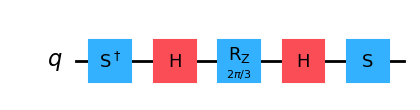

In [33]:
# Draw the circuit
qsp_circuit.draw(output="mpl")

In [35]:
# Check the output of the circuit and compare it with the psi
output = Statevector(qsp_circuit)
output.draw("latex")

<IPython.core.display.Latex object>

We again substitute $S H R_Z(\theta) H S^\dagger$ for $R_Y(\theta)$. 

We also need an expression for the controlled $R_Y$-gate $C R_Y$ in terms of the controlled $R_Z$ gate $C R_Z$. This is not difficult to obtain, since it also follows from the identity
$$
R_Y(\theta) = S H R_Z(\theta) H S^\dagger \quad \text{with } \,   (S H)^\dagger = H S^\dagger, 
$$
together with 
$$
CU= \ket{0} \bra{0} \otimes I + \ket{1} \bra{1} \otimes U \quad \text{for a general unitary } U \in U(2),
$$
that
$$
CR_Y(\theta) = \big(I\otimes (SH) \big) \, CR_Z(\theta) \, \big( I\otimes (H S^\dagger)\big).
$$

We are now ready to rewrite our circuit in terms of the $R_Z$ gate instead of $R_Y$.

In [37]:
psi = [1/2, 1/2, 1/2, 1/2]

# Define the angles that will be used with the R_Y gates

theta_0 = 2 * np.arccos(np.sqrt(np.sum(np.square(psi[:2]))))
theta_10 = 2 * np.arccos(psi[0] / np.sqrt(np.sum(np.square(psi[:2]))))
theta_11 = 2 * np.arccos(psi[2] / np.sqrt(np.sum(np.square(psi[2:]))))

# Define the circuit that prepares the state psi

quantum_register = QuantumRegister(size=2, name="q")
qsp_circuit = QuantumCircuit(quantum_register, name="Quantum State Preparation")

# Apply the equivalent of R_Y gate to qubit 1

qsp_circuit.sdg(quantum_register[1])
qsp_circuit.h(quantum_register[1])
qsp_circuit.rz(theta_0, quantum_register[1])
qsp_circuit.h(quantum_register[1])
qsp_circuit.s(quantum_register[1])

# Add barriers to make the circuit look more clear
qsp_circuit.barrier()

# Apply an X gate to qubit 1

qsp_circuit.x(quantum_register[1])

qsp_circuit.barrier()

# Apply the equivalent of a controlled R_Y gate with angle theta_10, with control on qubit 1, target on qubit 0

qsp_circuit.sdg(quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.crz(theta_10, quantum_register[1], quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.s(quantum_register[0])

qsp_circuit.barrier()

# Apply an X gate to qubit 1

qsp_circuit.x(quantum_register[1])

qsp_circuit.barrier()

# Apply the equivalent of a controlled R_Y gate with angle theta_11, with control on qubit 1, target on qubit 0

qsp_circuit.sdg(quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.crz(theta_11, quantum_register[1], quantum_register[0])
qsp_circuit.h(quantum_register[0])
qsp_circuit.s(quantum_register[0])

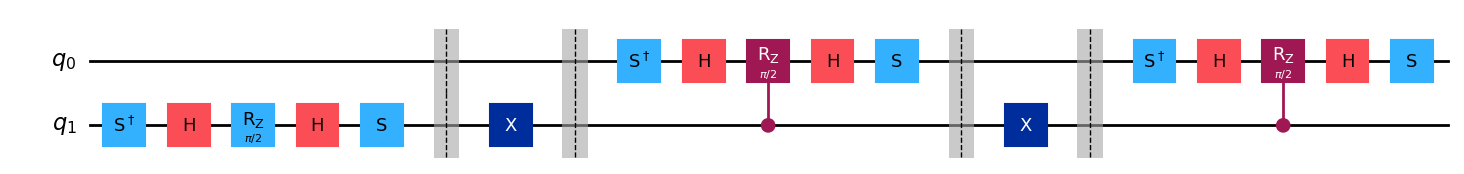

In [12]:
qsp_circuit.draw(output="mpl")

## Comments about the case $n\geq 3$.

**Note.** Let $n=3$ for this note. In Qiskit, the computational basis elements are listed in the same order as their bit correspondents:
$$
\ket{000}, \ket{001}, \ket{010}, \ket{011}, \ket{100},\ket{101},\ket{110}, \ket{111}. 
$$
We observe that the even indices run over basis elements with the zero qubit in the $\ket{0}$ state, while the odd indices run over basis elements where zero qubit is in the state $\ket{1}$.

Given a general $n$-qubit state $\psi$ with $n\geq 3$, we can write it as follows. 
$$
\psi = a \, \psi_0 \otimes \ket{0} + b\, \psi_1\otimes \ket{1} \quad \text{for }\,(n-1)\text{-qubit states }\, \psi_0, \psi_1, \,\, \text{for } \, a, b \geq 0 \, \text{ with } \, a^2+b^2=1. 
$$

Assume that the states $\psi_0, \psi_1$ can be prepared. 

We can rewrite $\psi$ as
$$
\psi = \cos\Big(\frac{\theta_0}{2}\Big) \psi_0 \ket{0}+ \sin\Big(\frac{\theta_0}{2}\Big) \psi_1 \ket{1},
$$
for $\theta_0 = 2\arccos(a)$, where $a = \Big(\sum_{\substack{x \in \mathbb{F}_2^n, \\ x\text{:even}}} \psi_x^2\Big)^{1/2}$. Our circuit above assumes that $a\neq 0$. 

Suppose that $a=0$. Then we must have $b=1$ since we assumed that $b\geq 0$, and we have $\psi = \psi_1 \otimes \ket{1}.$ This state can be prepared easily, supposing that the $(n-1)$-qubit state $\psi_1$ is prepared.

## Note.
We assumed positivity for the coordinates of the given vector $\psi$. In the definition of qsp_circuit function above, for a general vector $\psi$, we took into account the phases for each entry by applying a suitable diagonal gate. We illustrate this in the example below.

## Toy example. $n=1.$

In [13]:
# Choose a psi for the sake of the example
psi = [-1/np.sqrt(2)+1j/np.sqrt(2), 1/np.sqrt(2)+1j/np.sqrt(2)]

psi_phases = [np.e**(1j*np.angle(x)) for x in psi]
psi_phases_gate = DiagonalGate(psi_phases)

qc = QuantumCircuit(1)
qc.append(psi_phases_gate, qc.qubits)
Statevector(qc)

Statevector([-0.70710678+0.70710678j,  0.        +0.j        ],
            dims=(2,))


In [14]:
output = Statevector(qc)
output.draw('latex')

<IPython.core.display.Latex object>

## Example #1. $n=2 .$

In [17]:
psi = [1j/2, -1/2, 1/2, -1/2]
qc= qsp(psi)
Statevector(qc)

Statevector([-1.38777878e-16+5.00000000e-01j,
             -5.00000000e-01+2.77555756e-17j,
              5.00000000e-01-2.77555756e-17j,
             -5.00000000e-01+2.77555756e-17j],
            dims=(2, 2))


In [18]:
output = Statevector(qc)
output.draw('latex')

<IPython.core.display.Latex object>

## Example #2. $n=3 .$

In [19]:
psi = [1/(2*np.sqrt(2)), 1/(2*np.sqrt(2)), 1/(2*np.sqrt(2)), -1/(2*np.sqrt(2)), 1/(2*np.sqrt(2)),1/(2*np.sqrt(2)), 1/(2*np.sqrt(2)), -1/(2*np.sqrt(2))]
qc= qsp(psi)
Statevector(qc)

Statevector([ 0.35355339+1.11022302e-16j,  0.35355339-2.77555756e-17j,
              0.35355339+5.55111512e-17j, -0.35355339+2.77555756e-16j,
              0.35355339+1.38777878e-16j,  0.35355339+0.00000000e+00j,
              0.35355339-1.11022302e-16j, -0.35355339+3.60822483e-16j],
            dims=(2, 2, 2))


In [20]:
output = Statevector(qc)
output.draw('latex')

<IPython.core.display.Latex object>

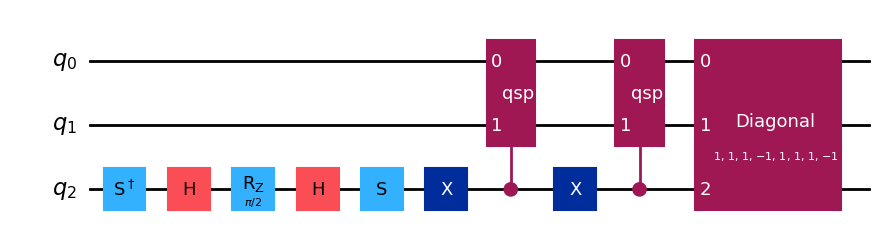

In [21]:
qsp(psi).draw('mpl')

## Example #3. $n=2 $ with a random unit vector.

In [22]:
# Define a random unit vector 

def random_complex_unit_vector(dim):
    """Generates a random unit vector in complex space.

    Args:
        dim: The dimension of the complex vector.

    Returns:
        A NumPy array representing the random unit complex vector.
    """
# Generate random complex numbers
    random_complex = np.random.rand(dim) + 1j * np.random.rand(dim)

# Normalize to get a unit vector
    unit_vector = random_complex / np.linalg.norm(random_complex)
    return unit_vector

# Example:
dimension = 4
unit_vector = random_complex_unit_vector(dimension)

In [23]:
unit_vector

array([0.32335863+0.38285183j, 0.00094241+0.39134739j,
       0.37623884+0.16489675j, 0.422407  +0.49853358j])

In [24]:
qc= qsp(unit_vector)
output= Statevector(qc)
output.draw('latex')

<IPython.core.display.Latex object>

## Example #4. $n=3 .$

Note that in the $3$-qubit state below, the even indexed qubit states have coefficients zero, and thus $a$ which was defined above is zero.

In [25]:
psi = [0, 1/2, 0, -1/2, 0, -1/2, 0, 1/2]
qc= qsp(psi)
Statevector(qc)

Statevector([ 0. +0.00000000e+00j,  0.5+8.32667268e-17j,
              0. +0.00000000e+00j, -0.5+1.38777878e-16j,
              0. +0.00000000e+00j, -0.5+1.66533454e-16j,
              0. +0.00000000e+00j,  0.5+0.00000000e+00j],
            dims=(2, 2, 2))


In [26]:
# Compare the output of the function with psi
output = Statevector(qc)
output.draw('latex')

<IPython.core.display.Latex object>